In [374]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import skimage.io as io

import h5py
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [309]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Image I/O and formatting workflows

This notebook will first demonstrate some workflows for reading and writing images to different formats using `cv2` (for fast image processing), `skimage.io` (convenient image I/O), and `h5py` (for data storage in HDF5 format). 

I'll then use these packages and their dependencies to draw and save ROIs and identify the brightest cell in a frame.

In [310]:
data_dir = "E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x/"

First, I'll read in a series of 5 consecutive brightfield images from a time-lapse experiment and convert them to an `ImageCollection` object.

In [110]:
# Read test images
vid = "0test"
ims_f = glob(os.path.join(data_dir, vid, "*/*CH4.tif"))

# Convert to image collection
#  Note: I use [::2] to skip every other image because of  
#    a quirk of the data I'm using.
arr = io.ImageCollection(ims_f)[::2].concatenate()

C:\Users\Pranav\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


We can now save this as a TIF stack, or multi-image TIF.

In [32]:
io.imsave(os.path.join(data_dir, vid, vid+".tiff"), arr)

Now let's perform the TIFF stack conversion for multiple videos. First, I'll extract the folder names for each video.

In [114]:
vids = [os.path.split(f)[-1] for f in glob(data_dir + "*_?")]
print(*vids, sep=", ")

10000_A, 10000_B, 10000_C, 1000_A, 1000_B, 1000_C, 160000_A, 160000_B, 160000_C, 20000_A, 20000_B, 20000_C, 2500_A, 2500_B, 2500_C, 40000_A, 40000_B, 40000_C, 5000_A, 5000_B, 5000_C, 80000_A, 80000_B, 80000_C


Now, we simply perform the same steps as before, for each video. We'll add a progress bar, since this could take a while.

In [115]:
iterator = vids
iterator = tqdm(iterator)
for vid in iterator:
    # Read images
    ims_f = glob(os.path.join(data_dir, vid, "*/*CH4.tif"))

    # Convert to image collection
    arr = io.ImageCollection(ims_f)[::2].concatenate()
    
    # Save as TIFF stack
    io.imsave(os.path.join(data_dir, vid, vid+"_BF.tiff"), arr)

100%|██████████| 24/24 [07:48<00:00, 19.53s/it]


One can also save the TIFF stack as an dataset in an HDF5 project.

In [20]:
# Create a new HDF5 file using default properties
file = h5py.File(os.path.join(data_dir, 'dset_test.h5'),'w')

# Save dataset to file
dset = file.create_dataset(vid+"_BF", data=arr)
file.close()

Now let's perform background subtraction on these TIFF stacks using cv2. As before, we start with a test-case of 5 images.

In [154]:
# Read TIF stack of test data
vid = "0test"
tif = glob(os.path.join(data_dir, vid, vid + "*.TIFF"))[0]
arr = io.imread(tif)

In [364]:
def bg_sub_bf(
    arr, bg_func=cv2.medianBlur, bg_args=(251, 0), pxval_range=(0, 255), norm=True
):
    """Background subtraction for brightfield time-lapse images."""
    arr_bgs = np.empty_like(arr)

    # Perform background subtraction
    for frame, im in enumerate(arr):

        # Construct strong median blur
        bg = bg_func(im, *bg_args)

        # Subtract background and normalize
        bg = bg - bg.min() + im.min()
        bgs = cv2.subtract(im, bg)
        
        if norm:
            bgs = cv2.normalize(bgs, bgs, *pxval_range, cv2.NORM_MINMAX)

        arr_bgs[frame] = bgs

    return arr_bgs

In [365]:
def bg_sub_gfp(
    arr, bg_func=cv2.medianBlur, bg_args=(251, 0), pxval_range=(0, 255), norm=True
):
    """Background subtraction for fluorescent time-lapse images."""
    arr_bgs = np.empty_like(arr)

    # Perform background subtraction
    for frame, im in enumerate(arr):

        # Construct strong median blur
        bg = bg_func(im, *bg_args)

        # Subtract background and normalize
        bg = np.ones_like(im, dtype=np.uint8) * im.min()
        bgs = cv2.subtract(im, bg)
        
        if norm:
            bgs = cv2.normalize(bgs, bgs, *pxval_range, cv2.NORM_MINMAX)

        arr_bgs[frame] = bgs

    return arr_bgs

In [157]:
# BG subtract and save
arr_bgs = bg_sub_bf(arr)
# io.imsave(os.path.join(data_dir, vid, vid+"_BF_bgs.TIFF"), arr_bgs)

Let's peek at the first frames to see if it worked.

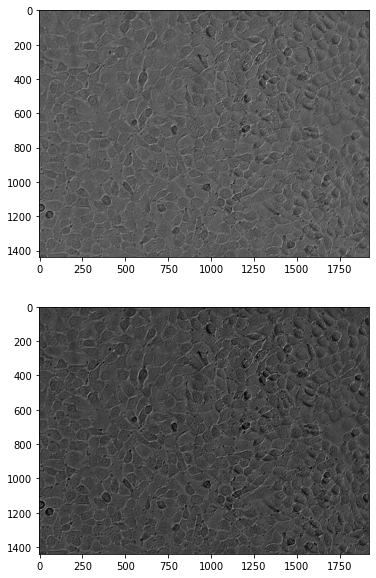

In [158]:
plotsize = 5
nplots = 2
fig, ax = plt.subplots(nplots, figsize=(plotsize * nplots,)*2)

ax[0].imshow(arr[4], "gray")
ax[1].imshow(arr_bgs[4], "gray")

Looks good! Let's now apply this to all our TIF stacks from above.

In [118]:
# Gather TIFF stacks
tiffs = glob(os.path.join(data_dir, "*", "*_BF.tiff"))
print(*tiffs, sep="\n")

E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\10000_A\10000_A_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\10000_B\10000_B_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\10000_C\10000_C_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\1000_A\1000_A_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\1000_B\1000_B_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\1000_C\1000_C_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\160000_A\160000_A_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\160000_B\160000_B_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\160000_C\160000_C_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x\20000_A\20000_A_BF.tiff
E:/transceiver_project/20200715_time_lapse_propagation/time_

In [119]:
iterator = tiffs
iterator = tqdm(iterator)
for tiff in iterator:
    
    # Read TIFF stack of raw data
    arr = io.imread(tiff)
    
    # Subtract background
    arr_bgs = bg_sub_bf(arr)
    
    # Save as TIFF stack
    tiff_bgs = tiff[:-5] + "_BF_bgs.TIFF"
    io.imsave(tiff_bgs, arr_bgs)

100%|██████████| 24/24 [11:57<00:00, 29.91s/it]


<hr>

Now let's try the same thing for GFP instead of brightfield.

In [312]:
# Read test images
vid = "0test"
ims_f = glob(os.path.join(data_dir, vid, "*/*CH1.tif"))

# Convert to image collection
#  Note: I use [::2] to skip every other image because of  
#    a quirk of the data I'm using.
arr = io.ImageCollection(ims_f)[::2].concatenate()

# Isolate Green channel (2nd channel)
arr = arr[:, :, :, 1]

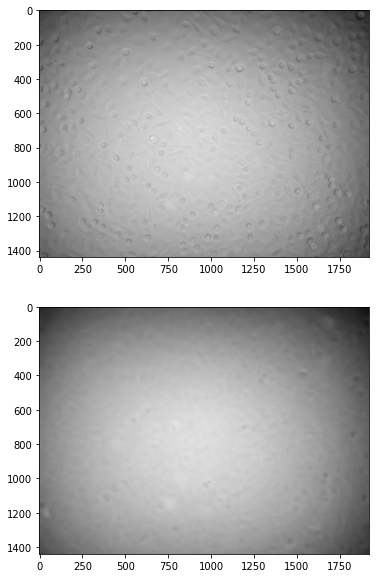

In [313]:
plotsize = 5
nplots = 2
fig, ax = plt.subplots(nplots, figsize=(plotsize * nplots,)*2)

ax[0].imshow(arr[0], "gray")
ax[1].imshow(arr[4], "gray")

We can now save this as a TIF stack, or multi-image TIF.

In [124]:
io.imsave(os.path.join(data_dir, vid, vid+"_GFP.tiff"), arr)

Now let's perform the TIFF stack conversion for multiple videos. First, I'll extract the folder names for each video.

In [151]:
vids = [os.path.split(f)[-1] for f in glob(data_dir + "*_?")]
print(*vids, sep=", ")

10000_A, 10000_B, 10000_C, 1000_A, 1000_B, 1000_C, 160000_A, 160000_B, 160000_C, 20000_A, 20000_B, 20000_C, 2500_A, 2500_B, 2500_C, 40000_A, 40000_B, 40000_C, 5000_A, 5000_B, 5000_C, 80000_A, 80000_B, 80000_C


Now, we simply perform the same steps as before, for each video. We'll add a progress bar, since this could take a while.

In [126]:
iterator = vids
iterator = tqdm(iterator)
for vid in iterator:
    # Read images
    ims_f = glob(os.path.join(data_dir, vid, "*/*CH1.tif"))

    # Convert to image collection
    arr = io.ImageCollection(ims_f)[::2].concatenate()
    arr = arr[:, :, :, 1]
    
    # Save as TIFF stack
    io.imsave(os.path.join(data_dir, vid, vid+"_GFP.tiff"), arr)

100%|██████████| 24/24 [10:46<00:00, 26.96s/it]


Now let's perform background subtraction again, this time using a different function. 

In [366]:
# Read TIF stack of test data
vid = "0test"
tif = glob(os.path.join(data_dir, vid, vid + "*_GFP.TIFF"))[0]
arr = io.imread(tif)

In [368]:
# BG subtract
arr_bgs  = bg_sub_gfp(arr, norm=False)

Let's plot a frame before and after to see if it worked.

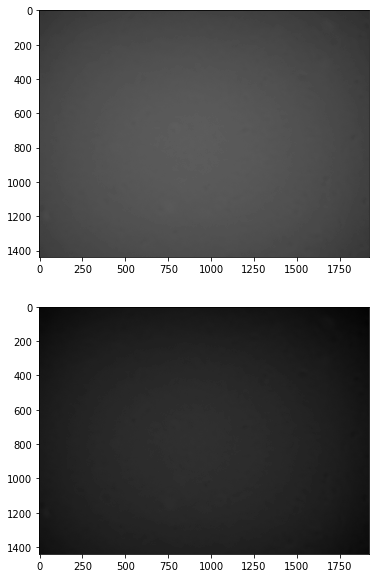

In [370]:
plotsize = 5
nplots = 2
fig, ax = plt.subplots(nplots, figsize=(plotsize * nplots,)*2)

ax[0].imshow(arr[-1], "gray", vmin=0, vmax=255)
ax[1].imshow(arr_bgs[-1], "gray", vmin=0, vmax=255)

Looks good! Let's save it.

In [371]:
# Save bg-subtracted TIFF stack
io.imsave(os.path.join(data_dir, vid, vid+"_GFP_bgs.tiff"), arr_bgs)

Now let's apply this to all our TIF stacks from above.

In [377]:
# Gather TIFF stacks of GFP channel
vids = [os.path.split(f)[-1] for f in glob(data_dir + "*_?")]
tiffs = glob(os.path.join(data_dir, "*", "*_?_GFP.tiff"))

In [379]:
iterator = tiffs
iterator = tqdm(iterator)
for tiff in iterator:
    
    # Read TIFF stack of raw data
    arr = io.imread(tiff)
    
    # Subtract background
    arr_bgs = bg_sub_gfp(arr, norm=False)
    
    # Save as TIFF stack
    tiff_bgs = tiff[:-5] + "_bgs.tiff"
    io.imsave(tiff_bgs, arr_bgs)

100%|██████████| 24/24 [12:01<00:00, 30.08s/it]


<hr>

### Example code for HDF5

In [21]:
# Open an existing file using default properties.
file = h5py.File(os.path.join(data_dir, 'dset_test.h5'),'r+')
keys = list(file.keys())
keys

['0test_BF']

In [23]:
# Open dataset under the root group.
key = '0test_BF'
arr = file[key]

In [24]:
arr_bgs = np.empty_like(arr)
for i, im in enumerate(arr):
    bg = cv2.medianBlur(im, 251, 0)
    bg = bg - bg.min()
    bgs = cv2.subtract(im, bg)
    bgs = cv2.normalize(bgs, bgs, 0, 255, cv2.NORM_MINMAX)
    arr_bgs[i] = bgs

In [25]:
dset = file.create_dataset(key+"_bgs", data=arr_bgs)
file.close()

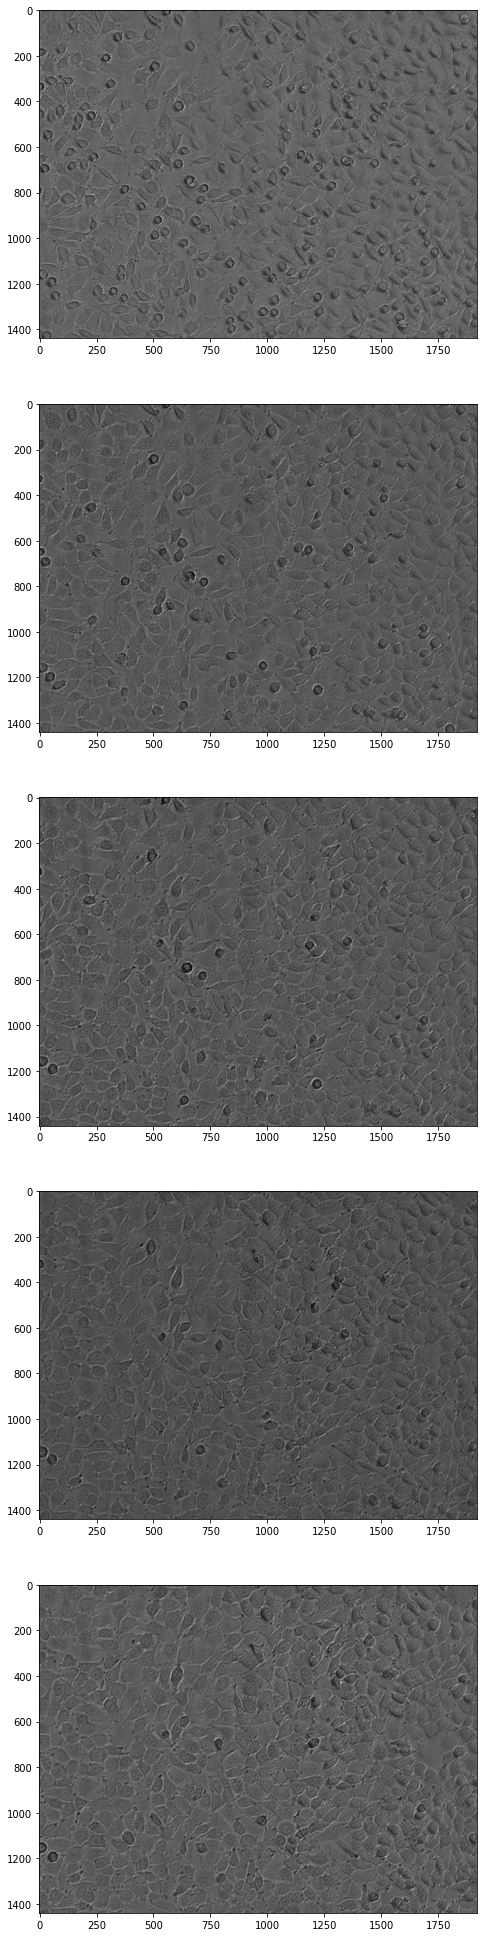

In [26]:
nplots = 5
fig, ax = plt.subplots(nplots, figsize=(7 * nplots, 7 * nplots))

ax[0].imshow(arr_bgs[0], "gray")
ax[1].imshow(arr_bgs[1], "gray")
ax[2].imshow(arr_bgs[2], "gray")
ax[3].imshow(arr_bgs[3], "gray")
ax[4].imshow(arr_bgs[4], "gray")

<hr>

In [64]:
import bebi103
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [56]:
data_dir = "E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x/"

In [57]:
vids = [os.path.split(f)[-1] for f in glob(data_dir + "*_?")]

In [74]:
roi_dict = {}

## Drawing ROIs from time-lapse data

Now let's draw ROIs for all the videos so that we can analyze signal propagation dynamics in the GFP channel. 

For each video, I have decided using some criteria whether or not to analyze it with respect to signal propagation. A time-lapse was rejected for propagation analysis if
- there were too few cells (leading to high variance in cell-wise metrics and inherently stochastic behaviors such as motility)
- the edge of the well impinges on the field of view
- there are other loci of signal propagation in addition to the one being studied, and the borders are difficult to delineate

I encode the outcomes of these exclusion criteria and the relevant frames for ROI drawing in the variable `roi_metadata`. I'll read in a TIFF stack as an ImageCollection, show the relevant images, draw the ROIs, and save those ROIs as a csv. 

In [188]:
# Store the information about ROI drawing for each time-lapse
#  1) Can this video be analyzed?
#  2) Does an ROI need to be drawn?
#  3) Which frames should be used to draw the ROI?
roi_metadata = [
    ["1000_A",   False, False, ()],
    ["1000_B",   False, False, ()],
    ["1000_C",   False, False, ()],
    ["2500_A",   True,  True,  (107, 147,)],
    ["2500_B",   False, False, ()],
    ["2500_C",   False, False, ()],
    ["5000_A",   False, False, ()],
    ["5000_B",   True,  False, ()],
    ["5000_C",   False, False, ()],
    ["10000_A",  False, False, ()],
    ["10000_B",  True,  True,  (69,)],
    ["10000_C",  True,  True,  (63,  86)],
    ["20000_A",  True,  True,  (57,  120,)],
    ["20000_B",  True,  True,  (71,  117,)],
    ["20000_C",  True,  True,  (59,)],
    ["40000_A",  True,  True,  (87,  118, 127,)],
    ["40000_B",  True,  True,  (89,  127, 162,)],
    ["40000_C",  True,  False, ()],
    ["80000_A",  True,  False, ()],
    ["80000_B",  True,  True,  (162,)],
    ["80000_C",  True,  True,  (162,)],
    ["160000_A", True,  True,  (151,)],
    ["160000_B", False, False, ()],
    ["160000_C", True,  True,  (162,)],
]

I'll draw the ROI by first displaying the relevant frame(s) and then using a function from the package `bebi103` to draw the ROI.

In [151]:
vid = "160000_C"
print(vid)
ims_f = glob(os.path.join(data_dir, vid, "*/*CH1.tif"))
arr = io.ImageCollection(ims_f)[::2].concatenate()

160000_C


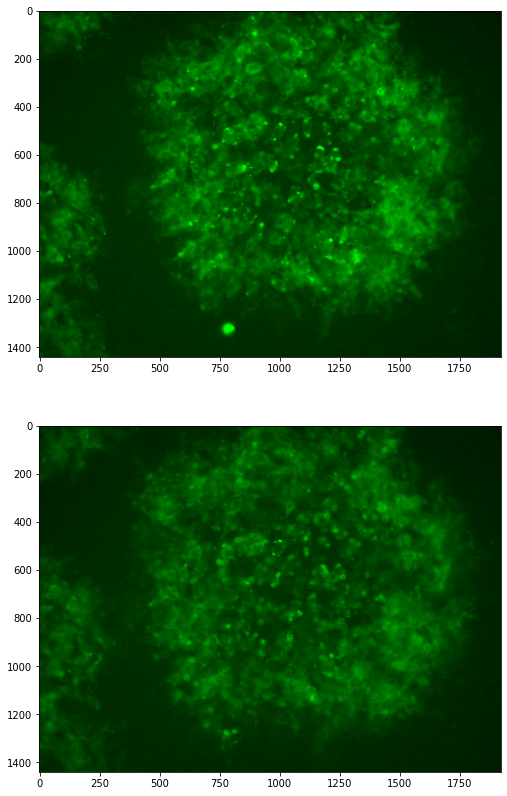

In [152]:
plotsize = 7
nplots = 2
fig, ax = plt.subplots(nplots, figsize=(plotsize * nplots,)*2)

ax[0].imshow(arr[151], "gray")
ax[-1].imshow(arr[-1], "gray")

In [154]:
rois = bebi103.image.draw_rois(arr[-1], flip=True)

C:\Users\Pranav\Anaconda3\lib\site-packages\bebi103\image.py:718: RuntimeWarning: invalid value encountered in true_divide
  im_rgb[:, :, i] /= im_rgb[:, :, i].max()
C:\Users\Pranav\Anaconda3\lib\site-packages\bebi103\image.py:751: RuntimeWarning: invalid value encountered in less
  if (im < 0).any() or (im > 1).any():
C:\Users\Pranav\Anaconda3\lib\site-packages\bebi103\image.py:751: RuntimeWarning: invalid value encountered in greater
  if (im < 0).any() or (im > 1).any():


In [155]:
roi_dict[vid] = bebi103.image.roicds_to_df(rois)

In [166]:
roi_dfs = []
for i, k in enumerate(roi_dict.keys()):
    roi_dict[k]["roi"] = i
    roi_dict[k]["video"] = k
    roi_dfs.append(roi_dict[k])
roi_df = pd.concat(roi_dfs)
roi_df.head(10)

,roi,x,y,video
0,0,244.953096,852.637500,2500_A
1,0,284.577861,445.837500,2500_A
2,0,335.009381,3.037500,2500_A
3,0,1556.172608,0.637509,2500_A
4,0,1916.397749,391.837500,2500_A
5,0,1912.795497,1114.237573,2500_A
6,0,1628.217636,1433.437537,2500_A
7,0,183.714822,1433.437537,2500_A
8,0,180.112570,1296.637537,2500_A
0,1,1768.705441,865.837573,10000_B


Somehow the y-coordinates got flipped, so I'll just fix this manually.

In [306]:
roi_df["y"] = arr.shape[0] - roi_df["y"]

Now let's find the location of the "center cell" in each video. Its fluorescence is recorded in both the red and blue channels. 

In [256]:
ctr_metadata = []
for vid, is_good, _, __ in roi_metadata:
    if is_good:
        im_f = glob(os.path.join(data_dir, vid, "T0001/*CH3.tif"))[0]
        arr = io.imread(im_f)
        gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        blur = cv2.medianBlur(gray, 51, 0)
        ctr = np.unravel_index(np.argmax(blur), blur.shape)
        ctr_win = np.s_[ctr[0]-50:ctr[0]+50, ctr[1]-50:ctr[1]+50]
        ctrw_im = arr.copy() 
        ctrw_im[ctr_win] += np.array([0, 30, 0], dtype=np.uint8)
        ctr_metadata.append((vid, ctr, ctr_win, ctrw_im))


For vid `10000_B`, this algorithm mis-assigns the sender cell (there's a very bright but inactive sender elsewhere in the frame). So let's identify this one by hand, using the `bebi103` package again. 

In [283]:
vid = "10000_B"
im_f = glob(os.path.join(data_dir, vid, "T0001/*CH3.tif"))[0]
arr = io.imread(im_f)
ctr_cds = bebi103.image.record_clicks(arr[:, :, 0], flip=True)

In [286]:
y, x = ctr_cds.to_df().values.ravel()
ctr = (int(x), int(y))
ctr_win = np.s_[ctr[0]-50:ctr[0]+50, ctr[1]-50:ctr[1]+50]

In [293]:
ctrw_im = arr.copy()
ctrw_im[ctr_win] += np.array([0, 30, 0], dtype=np.uint8)

In [294]:
which_10000_B = [i for i, x in enumerate(ctr_metadata) if x[0] == "10000_B"][0]
ctr_metadata[which_10000_B] = (vid, ctr, ctr_win, ctrw_im)

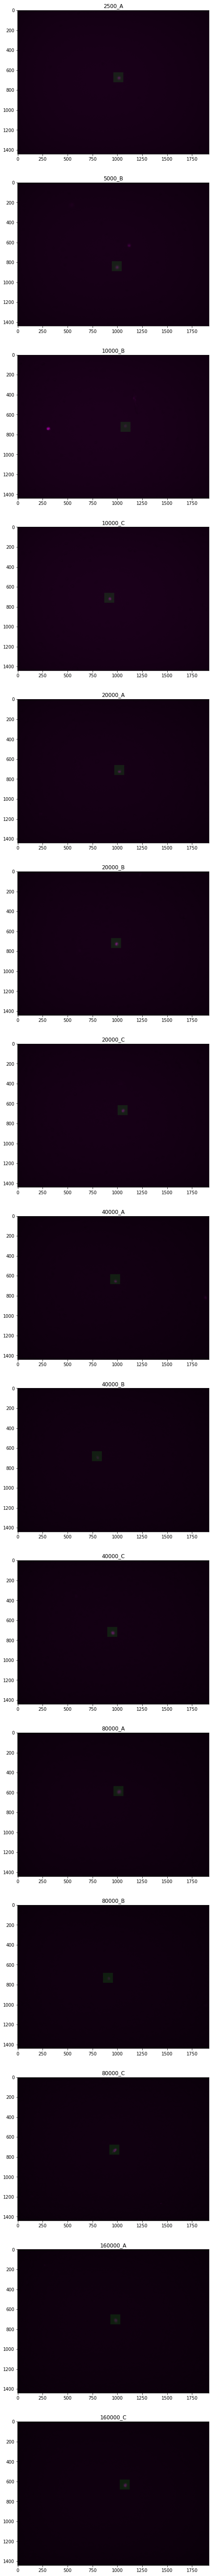

In [295]:
plotsize = 7
nplots = len(ctr_metadata)
fig, ax = plt.subplots(nplots, figsize=(plotsize * nplots,)*2)

i = 0
for vid, ctr, win, ctrw_im in ctr_metadata:
    arr = ctrw_im
    ax[i].imshow(arr, "gray")
    ax[i].set_title(vid)
    i += 1

In [302]:
vid_vals = [x[0] for x in ctr_metadata]
ctr_vals = [x[1] for x in ctr_metadata]
y_ctr_vals, x_ctr_vals = np.array(ctr_vals).T
ctr_df = pd.DataFrame(dict(
    video=vid_vals, 
    center_x_idx=x_ctr_vals, 
    center_y_idx=y_ctr_vals
))
ctr_df.head(10)

,video,center_x_idx,center_y_idx
0,2500_A,1012,671
1,5000_B,996,842
2,10000_B,1084,725
3,10000_C,921,711
4,20000_A,1021,710
5,20000_B,989,717
6,20000_C,1055,669
7,40000_A,980,636
8,40000_B,797,683
9,40000_C,951,717


Finally, let's save these DataFrames for use in further analysis.

In [307]:
roi_df.to_csv("../transceiver_timelapse_ROIs.csv")

In [303]:
ctr_df.to_csv("../transceiver_timelapse_centers.csv")